import the necessary libraries.

In [2]:
# Import libraries
import numpy as np
import matplotlib
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

%matplotlib inline

load the data

In [3]:
import pandas as pd

def load_data(file_path):
    return pd.read_csv(file_path, sep='\t')

# with images multimodal
train_data = load_data('/content/drive/MyDrive/multimodal_train.tsv')
validation_data = load_data('/content/drive/MyDrive/multimodal_validate.tsv')
test_data = load_data('/content/drive/MyDrive/multimodal_test_public.tsv')

# with and without  images unimodal
traindata_all = load_data('/content/drive/MyDrive/all_train.tsv')
validata_all = load_data('/content/drive/MyDrive/all_validate.tsv')
testdata_all = load_data('/content/drive/MyDrive/all_test_public.tsv')



Check the number of train, vaidation and test instances in each dataset. The prettytable library to create a table and display the data

In [4]:
from prettytable import PrettyTable

# Create a table
table = PrettyTable()

# Add columns to the table
table.field_names = ["Data", "Train", "Validation", "Test"]

# Add rows to the table
table.add_row(["AllData unimodal instances", len(traindata_all), len(validata_all), len(testdata_all)])
table.add_row(["Multimodal Data instances", len(train_data), len(validation_data), len(test_data)])


# Print the table
print(table)



+----------------------------+--------+------------+-------+
|            Data            | Train  | Validation |  Test |
+----------------------------+--------+------------+-------+
| AllData unimodal instances | 878218 |   92444    | 92444 |
| Multimodal Data instances  | 564000 |   59342    | 59319 |
+----------------------------+--------+------------+-------+


Print the first 5 rows of the traindata dataframe in a tabular format.

In [5]:
print(train_data.head().to_string())


           author                                                                                   clean_title   created_utc         domain  hasImage      id                                                                                                                                                   image_url linked_submission_id  num_comments  score          subreddit                                                                                         title  upvote_ratio  2_way_label  3_way_label  6_way_label
0     Alexithymia  my walgreens offbrand mucinex was engraved with the letters mucinex but in a different order  1.551641e+09    i.imgur.com      True  awxhir  https://external-preview.redd.it/WylDbZrnbvZdBpgfa3ntxYf17CBHndiJWHylVm2j_nY.jpg?width=320&crop=smart&auto=webp&s=449659a10792de4d55c2f27d2176fdc8bc66e72a                  NaN           2.0     12  mildlyinteresting  My Walgreens offbrand Mucinex was engraved with the letters Mucinex but in a different order        

In [ ]:
print(train_data["hasImage"].dtype)

Use the .sum() method to count the number of instances that have an image.

The train, validation and test sets (that is, the multimodal_train, multimodal_vaidate and multimodal_test_pulic sets) all have corresponding images.

In [7]:
print("Number of train instances that have images: ",train_data['hasImage'].sum())
print("Number of validation instances that have images: ",validation_data['hasImage'].sum())
print("Number of test instances that have images: ",test_data['hasImage'].sum())


Number of train instances that have images:  564000
Number of validation instances that have images:  59342
Number of test instances that have images:  59319


Data contained in all_train, all_validate and all_test_public datasets. 

Unimodal datasets have no image

In [8]:
train_no_image = (traindata_all['hasImage'] == False).sum()
print("Number of train instances that don`t have images: ", train_no_image)

validation_no_image = (validata_all['hasImage'] == False).sum()
print("Number of validation instances that don`t have images: ", validation_no_image)

test_no_image = (testdata_all['hasImage'] == False).sum()
print("Number of test instances that don`t have images: ", test_no_image)


Number of train instances that don`t have images:  239117
Number of validation instances that don`t have images:  25236
Number of test instances that don`t have images:  25189


Uses the dropna() method to remove rows with missing values for the clean_title column for all datasets:

In [9]:
# MULTIMODAL DATASET
# Train data with no missing values
train_data = train_data.dropna(subset=['clean_title'])
# Validation data with no missing values
valid_data = validation_data.dropna(subset=['clean_title'])
# Test data with no missing values
test_data = test_data.dropna(subset=['clean_title'])

# UNIMODAL DATASET
all_train_data = traindata_all.dropna(subset=['clean_title'])
# Validation data with no missing values
all_valid_data = validata_all.dropna(subset=['clean_title'])
# Test data with no missing values
all_test_data = testdata_all.dropna(subset=['clean_title'])



Use the .loc accessor to select the necessary columns for the train_frame, train_labels, valid_frame, valid_labels, test_frame, and test_labels variables.

In [10]:
# MULTIMODAL DATASET
# Train data (text and labels)
train_frame = train_data.loc[:, 'clean_title']
train_labels = train_data.loc[:, '6_way_label']
# Validation data (text and labels)
valid_frame = valid_data.loc[:, 'clean_title']
valid_labels = valid_data.loc[:, '6_way_label']
# Test data (text and labels)
test_frame = test_data.loc[:, 'clean_title']
test_labels = test_data.loc[:, '6_way_label']

# UNIMODAL DATASET
all_train_frame = all_train_data.loc[:, 'clean_title']
all_train_labels = all_train_data.loc[:, '6_way_label']
# Validation data (text and labels)
all_valid_frame = all_valid_data.loc[:, 'clean_title']
all_valid_labels = all_valid_data.loc[:, '6_way_label']
# Test data (text and labels)
all_test_frame = all_test_data.loc[:, 'clean_title']
all_test_labels = all_test_data.loc[:, '6_way_label']


**Class distribution for the unimodal dataset**

Plot the class distribution for the multimodal and unimodal (all data) datastets.

Unimodal (all data)

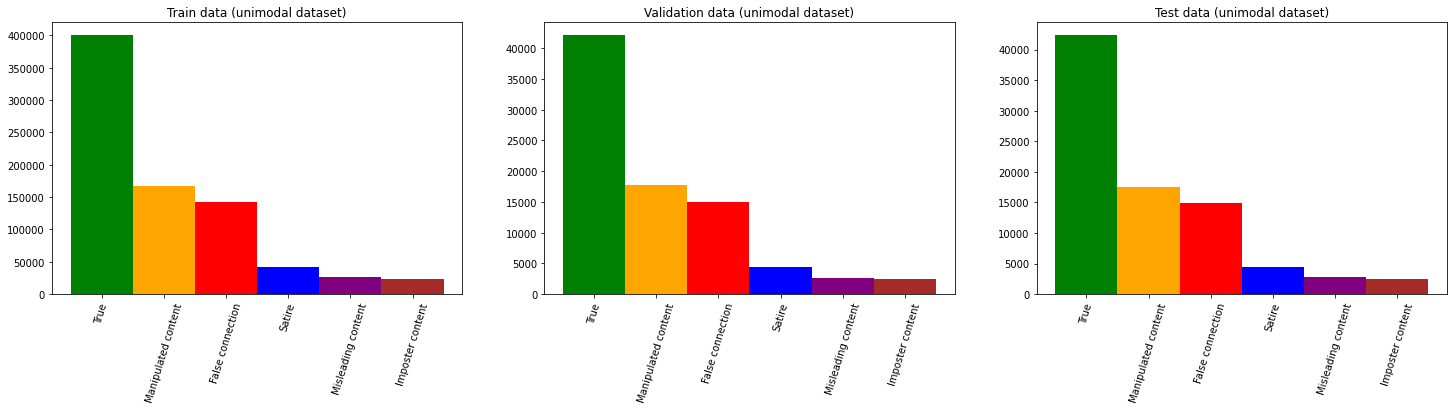

In [11]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5))

width = 0.3
labels = ['True','Manipulated content','False connection','Satire','Misleading content','Imposter content']
x_pos_labs = [i-width for i in range(1, len(labels)*2+1, 2)]
color = ['green','orange','red','blue','purple','brown']

# Plot the train_labels_all data on the first subplot
ax[0].bar(x_pos_labs, height = all_train_labels.value_counts(), width = 2, color = color )
ax[0].set_title("Train data (unimodal dataset)")
ax[0].set_xticks(x_pos_labs)
ax[0].set_xticklabels(labels, rotation=73)

# Plot the valid_labels_all data on the second subplot
ax[1].bar(x_pos_labs, height = all_valid_labels.value_counts(), width = 2, color = color )
ax[1].set_title("Validation data (unimodal dataset)")
ax[1].set_xticks(x_pos_labs)
ax[1].set_xticklabels(labels, rotation=73)

# Plot the test_labels_all data on the third subplot
ax[2].bar(x_pos_labs, height = all_test_labels.value_counts(), width = 2, color = color )
ax[2].set_title("Test data (unimodal dataset)")
ax[2].set_xticks(x_pos_labs)
ax[2].set_xticklabels(labels, rotation=73)

plt.show()


**Class distribution for the multimodal dataset**

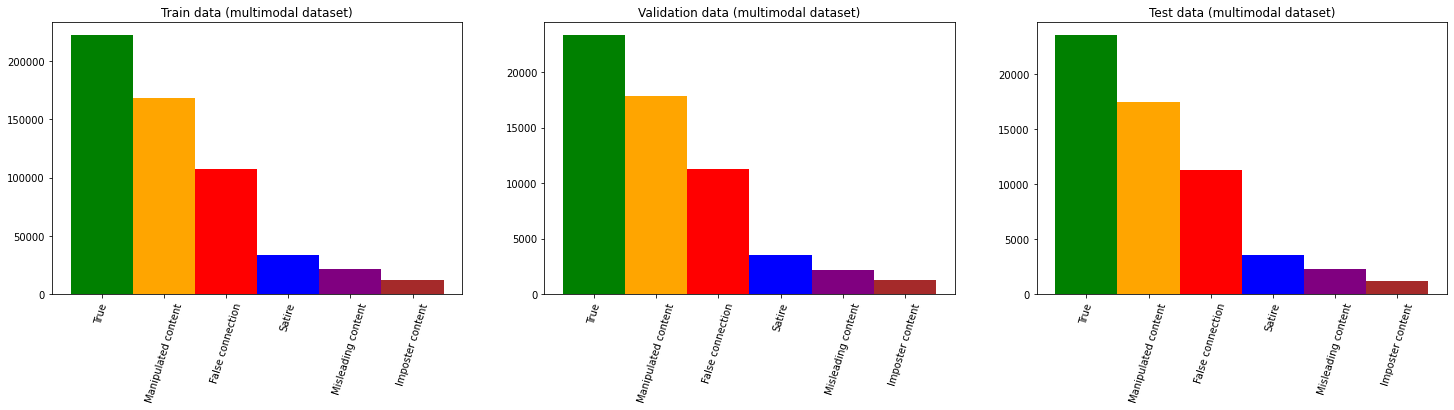

In [12]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,5))

width = 0.3
labels = ['True','Manipulated content','False connection','Satire','Misleading content','Imposter content']
x_pos_labs = [i-width for i in range(1, len(labels)*2+1, 2)]
color = ['green','orange','red','blue','purple','brown']

# Plot the train_labels_all data on the first subplot
ax[0].bar(x_pos_labs, height = train_labels.value_counts(), width = 2, color = color )
ax[0].set_title("Train data (multimodal dataset)")
ax[0].set_xticks(x_pos_labs)
ax[0].set_xticklabels(labels, rotation=73)

# Plot the valid_labels_all data on the second subplot
ax[1].bar(x_pos_labs, height = valid_labels.value_counts(), width = 2, color = color )
ax[1].set_title("Validation data (multimodal dataset)")
ax[1].set_xticks(x_pos_labs)
ax[1].set_xticklabels(labels, rotation=73)

# Plot the test_labels_all data on the third subplot
ax[2].bar(x_pos_labs, height = test_labels.value_counts(), width = 2, color = color )
ax[2].set_title("Test data (multimodal dataset)")
ax[2].set_xticks(x_pos_labs)
ax[2].set_xticklabels(labels, rotation=73)

plt.show()

**Multi-Class Text Classification**

uses a for loop to iterate through the different labels and calculate the proportion of each label in each data set.

the data is being prepared for a multi-class text classification task. The code is extracting the "clean_title" and "6_way_label" columns from the train_data, valid_data, and test_data DataFrames. It then calculates the proportion of each label in the train_labels, valid_labels, and test_labels series. These proportions are stored in variables with names like "train_0" and "validation_1". These variables are then used to create a new DataFrame, proportion_data, which has columns for the label, the proportion of that label in the training data, the proportion of that label in the validation data, and the proportion of that label in the test data.

In [13]:
# Get series objects for the necessary columns
train_frame = train_data["clean_title"]
train_labels = train_data["6_way_label"]
valid_frame = valid_data["clean_title"]
valid_labels = valid_data["6_way_label"]
test_frame = test_data["clean_title"]
test_labels = test_data["6_way_label"]
labels = ['True','Satire','False connection','Imposter content','Manipulated content','Misleading content']

# Get proportions of each label in each data set
data_sets = [train_labels, valid_labels, test_labels]
proportions = []
for data in data_sets:
    proportion = []
    for i in range(6):
        proportion.append(sum(data == i)/len(data))
    proportions.append(proportion)

# Create dataframe with proportions
d = {"Label":labels, "Traindata": proportions[0], "Validata": proportions[1], "Testdata": proportions[2]}
proportion_data = pd.DataFrame(data = d)
proportion_data

,Label,Traindata,Validata,Testdata
0,True,0.393761,0.392976,0.396281
1,Satire,0.059363,0.059334,0.059239
2,False connection,0.190108,0.190034,0.190445
3,Imposter content,0.020894,0.020862,0.020634
4,Manipulated content,0.297619,0.300125,0.294543
5,Misleading content,0.038255,0.036669,0.038858


**Preprocessing**

remove punctuations and numbers and also multiple spaces


The 'series' data is converted to list using the tolist() method which is more efficient than the list() constructor.
The string.punctuation constant is used to remove all punctuation characters from the text.

In [14]:
import re
import string

# Convert 'series' data to list

## Texts ##

# Train
train_list = train_frame.tolist()
# Valid
valid_list = valid_frame.tolist()
# Test
test_list = test_frame.tolist()

## Labels ##

# Train
train_labels_list = train_labels.tolist()
# Valid
valid_labels_list = valid_labels.tolist()
# Test
test_labels_list = test_labels.tolist()

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[{}]'.format(string.punctuation), '', sen)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

# Remove puntuations and numbers and multiple spaces

train_news_clean = []
valid_news_clean = []
test_news_clean = []

# Train
train_news_clean = [preprocess_text(new) for new in train_list]
# Validation
valid_news_clean = [preprocess_text(new) for new in valid_list]
# Test
test_news_clean = [preprocess_text(new) for new in test_list]



Use multiprocessing to perform the tokenization and stopwords removal on multiple cores.

In [15]:
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords_stem(text):
  text = word_tokenize(text)
  # Stop words removal
  text = [word for word in text if word.lower() not in stop_words]
  # Stemming
  stemmer = PorterStemmer()
  stemmed_text = [stemmer.stem(word) for word in text]
  text_done = ' '.join(stemmed_text)
  return text_done

# Train stemmed
train_stemmed = [remove_stopwords_stem(text) for text in train_news_clean]

# Validation stemmed
valid_stemmed = [remove_stopwords_stem(text) for text in valid_news_clean]

# Test stemmed
test_stemmed = [remove_stopwords_stem(text) for text in test_news_clean]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


First, the code imports the necessary libraries and sets up a stemmer and a set of stop words using the nltk library. The stemmer is used to stem words to their root form, while the stop words are commonly used words in a language that are removed from text in order to improve the performance of natural language processing tasks.

In [16]:
import nltk
nltk.download('omw-1.4')

try:
    nltk.data.find('wordnet')
except LookupError:
    nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def remove_stopwords_lem(text):
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]
    lemmatized_text = []
    for word in text:
        word1 = lemmatizer.lemmatize(word, pos = "n")
        word2 = lemmatizer.lemmatize(word1, pos = "v")
        word3 = lemmatizer.lemmatize(word2, pos = ("a"))
        lemmatized_text.append(word3) 
    text_done = ' '.join(lemmatized_text)
    return text_done

train_lemmatized = list(map(remove_stopwords_lem, train_news_clean))
valid_lemmatized = list(map(remove_stopwords_lem, valid_news_clean))
test_lemmatized = list(map(remove_stopwords_lem, test_news_clean))


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


It is used in the 'classifier' step of the pipeline. The pipeline first performs feature extraction using the CountVectorizer and TfidfTransformer, and then trains the MultinomialNB classifier on the extracted features to make predictions.

**Stemming**


Multinomial Naive Bayes

In [17]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter search space
param_grid = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__min_df': [5, 10, 15],
              'tfidf__sublinear_tf': [True, False],
              'classifier__alpha': [0.1, 1, 10]}

# Create pipeline
pipe = Pipeline([('vect', CountVectorizer()), 
                 ('tfidf', TfidfTransformer()), 
                 ('classifier', MultinomialNB())])

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the data
grid_search.fit(train_stemmed, train_labels_list)

# Get the predictions on the validation data
valid_predictions = grid_search.predict(valid_stemmed)

# Compute the accuracy
acc = accuracy_score(valid_labels_list, valid_predictions)

print("Accuracy: ", acc)


# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters: ", best_params)

# Get the best score
best_score = grid_search.best_score_
print("Best score: ", best_score)




Fitting 5 folds for each of 36 candidates, totalling 180 fits
Accuracy:  0.6614202419871255
Best hyperparameters:  {'classifier__alpha': 0.1, 'tfidf__sublinear_tf': True, 'vect__min_df': 5, 'vect__ngram_range': (1, 2)}
Best score:  0.6561312056737588


Logistic Regression

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score

# Define the pipeline
Logistic_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression(random_state = 3))
])

# Define the hyperparameter grid to search
param_grid = {
    'vect__ngram_range': [(1,1), (1,2)],
    'vect__min_df': [5,10,15],
    'tfidf__sublinear_tf': [True, False],
    'classifier__solver': ['saga'],
    'classifier__multi_class': ['ovr'],
    'classifier__C': [0.1, 0.5, 1],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(Logistic_pipe, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(train_stemmed, train_labels_list)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Obtain the predictions on the validation set
predictions = grid_search.predict(valid_stemmed)

# Obtain the accuracy
acc = accuracy_score(valid_labels_list, predictions)

print("Accuracy: ", acc)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters: ", best_params)

# Print the best score
print("Best score: ", acc)



Best hyperparameters:  {'classifier__C': 1, 'classifier__multi_class': 'ovr', 'classifier__solver': 'saga', 'tfidf__sublinear_tf': True, 'vect__min_df': 5, 'vect__ngram_range': (1, 2)}
Accuracy:  0.7093458258906002
Best hyperparameters:  {'classifier__C': 1, 'classifier__multi_class': 'ovr', 'classifier__solver': 'saga', 'tfidf__sublinear_tf': True, 'vect__min_df': 5, 'vect__ngram_range': (1, 2)}
Best score:  0.7093458258906002


Random Forest

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score

# Define the pipeline
Forest_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier(random_state = 3))
])

# Define the hyperparameter grid to search
param_grid = {
    'vect__ngram_range': [(1,1), (1,2)],
    'vect__min_df': [5,10,15],
    'tfidf__sublinear_tf': [True, False],
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [3, 4, 5],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(Forest_pipe, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(train_stemmed, train_labels_list)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Obtain the predictions on the validation set
predictions = grid_search.predict(valid_stemmed)

# Obtain the accuracy
acc = accuracy_score(valid_labels_list, predictions)

print("Accuracy: ", acc)

# Print the best score
print("Best score: ", acc)


Best hyperparameters:  {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'tfidf__sublinear_tf': True, 'vect__min_df': 5, 'vect__ngram_range': (1, 1)}
Accuracy:  0.39301000977385325
Best score:  0.39301000977385325


LinearSVC

In [22]:

from sklearn.model_selection import GridSearchCV

# Define the pipeline
SVC_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LinearSVC(random_state = 3))
])

# Define the hyperparameter grid to search
param_grid = {
    'vect__ngram_range': [(1,1), (1,2)],
    'vect__min_df': [5,10,15],
    'tfidf__sublinear_tf': [True, False],
    'classifier__max_iter': [1000, 1500, 2000, 2500, 3000],
    'classifier__loss': ['squared_hinge']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(SVC_pipe, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(train_stemmed, train_labels_list)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Obtain the predictions on the validation set
predictions = grid_search.predict(valid_stemmed)

# Obtain the accuracy
acc = accuracy_score(valid_labels_list, predictions)

print("Accuracy: ", acc)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters: ", best_params)

# Print the best score
print("Best score: ", acc)

Best hyperparameters:  {'classifier__loss': 'squared_hinge', 'classifier__max_iter': 1000, 'tfidf__sublinear_tf': True, 'vect__min_df': 5, 'vect__ngram_range': (1, 2)}
Accuracy:  0.7205183512520643
Best hyperparameters:  {'classifier__loss': 'squared_hinge', 'classifier__max_iter': 1000, 'tfidf__sublinear_tf': True, 'vect__min_df': 5, 'vect__ngram_range': (1, 2)}
Best score:  0.7205183512520643


Lemmatization

Naive Bayes

In [23]:
from sklearn.model_selection import GridSearchCV

# Define the pipeline
Bayes_pipe = Pipeline([('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                       ('classifier', MultinomialNB())
                      ])

# Define the hyperparameter grid to search
param_grid = {
    'vect__ngram_range': [(1,1), (1,2)],
    'vect__min_df': [5,10,15],
    'tfidf__sublinear_tf': [True, False],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(Bayes_pipe, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(train_lemmatized, train_labels_list)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

# Obtain the predictions on the validation set
predictions = grid_search.predict(valid_lemmatized)

# Obtain the accuracy
acc = accuracy_score(valid_labels_list, predictions)
print("Accuracy: ", acc)

# Print the best score
print("Best score: ", acc)

Best hyperparameters:  {'tfidf__sublinear_tf': True, 'vect__min_df': 5, 'vect__ngram_range': (1, 2)}
Accuracy:  0.650230865154528
Best score:  0.650230865154528


Logistic Regression

In [24]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__min_df': [5, 10, 15],
              'tfidf__sublinear_tf': [True, False],
              'classifier__solver': ['saga'],
              'classifier__multi_class': ['ovr'],
              'classifier__C': [0.1, 0.5, 1],
              }

# Create the pipeline
Logistic_pipe = Pipeline([('vect', CountVectorizer()),
                          ('tfidf', TfidfTransformer()),
                          ('classifier', LogisticRegression(random_state = 3))])

# Perform grid search
grid_search = GridSearchCV(Logistic_pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_lemmatized, train_labels_list)

# Best hyper-parameters
print("Best hyper-parameters: ")
print(grid_search.best_params_)

# Best score
print("Best score: ")
print(grid_search.best_score_)

# Obtain the accuracy
acc = accuracy_score(valid_labels_list, predictions)
print("Accuracy: ", acc)


Best hyper-parameters: 
{'classifier__C': 1, 'classifier__multi_class': 'ovr', 'classifier__solver': 'saga', 'tfidf__sublinear_tf': True, 'vect__min_df': 5, 'vect__ngram_range': (1, 2)}
Best score: 
0.7056294326241135
Accuracy:  0.650230865154528


Random Forest

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np

# Define pipeline
Forest_pipe = Pipeline([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('classifier', RandomForestClassifier(random_state=3))])

# Define parameter grid
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__min_df': [5, 10, 15],
    'tfidf__sublinear_tf': [True, False],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [3, 4, 5]
}

# Create GridSearchCV object
grid_search = GridSearchCV(Forest_pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit grid search
grid_search.fit(train_lemmatized, train_labels_list)

# Best hyper-parameters
print("Best hyper-parameters: ")
print(grid_search.best_params_)

# Best score
print("Best score: ")
print(grid_search.best_score_)

# Obtain the accuracy
acc = accuracy_score(valid_labels_list, predictions)
print("Accuracy: ", acc)


Best hyper-parameters: 
{'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'tfidf__sublinear_tf': True, 'vect__min_df': 15, 'vect__ngram_range': (1, 1)}
Best score: 
0.39399290780141843
Accuracy:  0.650230865154528


Model Evaluation

In the first step, the train and validation data sets are joined, as well as their labels. The model is then trained using a pipeline, which first applies the CountVectorizer to convert the text data into numerical feature vectors, followed by the TfidfTransformer to scale the feature values

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import GridSearchCV
import numpy as np

# Join train and validation sets
training_stemmed = train_stemmed + valid_stemmed
training_lemmatized =  train_lemmatized + valid_lemmatized

# Joining train and validation labels
training_labels = train_labels_list + valid_labels_list

Naive Bayes

In [27]:

# Define the pipeline for Naive Bayes
Bayes_pipe = Pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer()),('classifier', MultinomialNB() )])

# Define the hyper-parameter grid for GridSearchCV
param_grid = {
    'vect__ngram_range': [(1,1),(1,2)],
    'vect__min_df': [5,10,15],
    'tfidf__sublinear_tf': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(Bayes_pipe, param_grid, cv=5, scoring='accuracy', return_train_score=True)

# Fit the GridSearchCV on the data
grid_search.fit(training_stemmed, training_labels)

# Best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Evaluation of the best model on the test data
predictions_Bayes_stem = grid_search.predict(test_stemmed)
print(classification_report(np.array(test_labels_list).reshape(len(test_labels),1),predictions_Bayes_stem))


Best parameters:  {'tfidf__sublinear_tf': True, 'vect__min_df': 5, 'vect__ngram_range': (1, 2)}
Best score:  0.6473268301831299
              precision    recall  f1-score   support

           0       0.61      0.90      0.73     23507
           1       0.84      0.10      0.17      3514
           2       0.72      0.44      0.55     11297
           3       0.91      0.01      0.02      1224
           4       0.69      0.66      0.68     17472
           5       0.92      0.33      0.48      2305

    accuracy                           0.65     59319
   macro avg       0.78      0.41      0.44     59319
weighted avg       0.69      0.65      0.62     59319



In [28]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1),predictions_Bayes_stem))

[[21047    21   826     0  1605     8]
 [ 1927   334   213     0  1033     7]
 [ 4476    17  4994     0  1772    38]
 [  782     2    71    10   355     4]
 [ 5242    18   616     1 11584    11]
 [  979     6   230     0   334   756]]


LinearSVC

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC



# Train the model using the best parameters
best_SVC_pipe = Pipeline([('vect', CountVectorizer(ngram_range=best_params['vect__ngram_range'], 
                                                   min_df=best_params['vect__min_df'])),
                         ('tfidf', TfidfTransformer(sublinear_tf=best_params['tfidf__sublinear_tf'])),
                         ('classifier', LinearSVC(random_state=3, max_iter=best_params['classifier__max_iter'], 
                                                   loss=best_params['classifier__loss']) )])
best_SVC_pipe.fit(training_stemmed, training_labels)

# Evaluation of the model
predictions_SVC_stem = best_SVC_pipe.predict(test_stemmed)
print(classification_report(np.array(test_labels).reshape(len(test_labels),1),predictions_SVC_stem))


              precision    recall  f1-score   support

           0       0.74      0.85      0.79     23507
           1       0.57      0.27      0.37      3514
           2       0.67      0.54      0.60     11297
           3       0.54      0.15      0.23      1224
           4       0.74      0.82      0.78     17472
           5       0.75      0.55      0.64      2305

    accuracy                           0.72     59319
   macro avg       0.67      0.53      0.57     59319
weighted avg       0.71      0.72      0.71     59319



In [37]:
# Confusion matrix
print(confusion_matrix(np.array(test_labels).reshape(len(test_labels),1),predictions_SVC_stem))

[[19978   263  1418    59  1624   165]
 [ 1114   955   296    25  1064    60]
 [ 2946   158  6153    33  1905   102]
 [  642    38   130   183   203    28]
 [ 1878   194   984    26 14326    64]
 [  619    53   168    14   182  1269]]
